In [11]:

%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from get_data import get_option_data
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [3]:
option_dfs = {}
for file_name in glob.glob("data/"+'*.csv'):
    option_id = file_name[5:-4]
    option_dfs[option_id]  = pd.read_csv(file_name, index_col=0)

In [4]:
option_df = option_dfs[option_id]
option_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,S
1580744,112878,2014-01-23,20140517,20140123.0,C,820000,13.8,16.3,1,0.116460,102586106,NaN,1,CBOE S&P 100 INDEX,E,818.460022
1582036,112878,2014-01-24,20140517,20140123.0,C,820000,10.7,12.3,0,0.130208,102586106,NaN,1,CBOE S&P 100 INDEX,E,812.130005
1583242,112878,2014-01-27,20140517,20140127.0,C,820000,8.6,10.8,1,0.127482,102586106,NaN,1,CBOE S&P 100 INDEX,E,796.280029
1584448,112878,2014-01-28,20140517,20140127.0,C,820000,8.3,10.4,0,0.119698,102586106,NaN,1,CBOE S&P 100 INDEX,E,792.510010
1585654,112878,2014-01-29,20140517,20140127.0,C,820000,6.4,8.4,0,0.122803,102586106,NaN,1,CBOE S&P 100 INDEX,E,795.500000


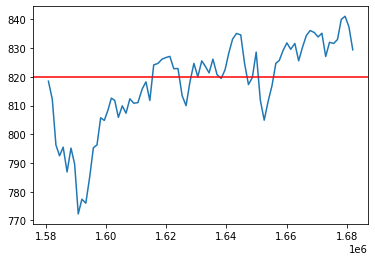

In [5]:
option_df.S.plot()
plt.axhline(y=option_df["strike_price"].iloc[0] / 1000, color='r', linestyle='-')

In [6]:
# Get params dependent on data
strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

In [10]:
# Remaining params to determine
n_simulations = 10_000
rf = 0
fc_dims = [32, 32, 32]
LR = 0.005
EPOCHS = 10
BATCH_SIZE = 1000

In [8]:
# Using implied volatility should give back market price 
price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

(15.05, 20.54619183494765)

In [12]:
bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=True)
optimizer = Adam(cn.parameters(), lr=LR)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.MSELoss()

for i in range(3):
    
    dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
    data_loader_train = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True)
    train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

Epoch 0: : 0batch [00:02, ?batch/s]/root/projects/uni/fml/FML/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 10batch [00:17,  1.71s/batch, loss=613]
Epoch 1: : 10batch [00:13,  1.36s/batch, loss=418]
Epoch 2: : 10batch [00:13,  1.35s/batch, loss=216]
Epoch 3: : 10batch [00:11,  1.16s/batch, loss=33.4]
Epoch 4: : 10batch [00:09,  1.11batch/s, loss=36.9]
Epoch 5: : 10batch [00:09,  1.06batch/s, loss=9.49]
Epoch 6: : 10batch [00:14,  1.42s/batch, loss=10.7]
Epoch 7: : 10batch [00:09,  1.09batch/s, loss=7.85]
Epoch 8: : 10batch [00:09,  1.09batch/s, loss=7.02]
Epoch 9: : 10batch [00:08,  1.14batch/s, loss=6.2]
Epoch 0: : 10batch [00:09,  1.08batch/s, loss=7.5]
Epoch 1: : 10batch [00:09,

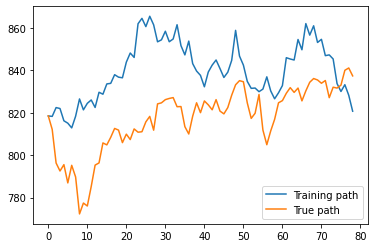

In [13]:
# Visualize an example training path and the true path

a, b, c, d, = next(iter(data_loader_train))
plt.plot(a[0], label="Training path")
plt.plot(x.squeeze(), label="True path")
plt.legend()

In [15]:
x.shape

torch.Size([1, 79, 1])

In [27]:
print(f"{price=}")

# Model
cn.eval_mode()

hedge, learned_price = cn(x)
si = stochastic_integral(torch.Tensor(x_inc), hedge)

print(f"{learned_price=}")  # this is roughly BS price using the imp. vola

ml_mkt_price = (price + si - payoff) ** 2
ml_learned_price = (learned_price + si - payoff) ** 2
print(f"{ml_mkt_price=}")
print(f"{ml_learned_price=}")

# Delta hedge benchmark
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
si = stochastic_integral(x_inc, d_hedge)
dl_mkt_price = (price + si - payoff) ** 2
dl_learned_price = (learned_price + si - payoff) ** 2
 
print(f"{dl_mkt_price=}")
print(f"{dl_learned_price=}")

price=15.05
learned_price=tensor([[20.1246]], grad_fn=<AddmmBackward>)
ml_mkt_price=tensor(20.0895, grad_fn=<PowBackward0>)
ml_learned_price=tensor([[0.3511]], grad_fn=<PowBackward0>)
dl_mkt_price=tensor(1.7756)
dl_learned_price=tensor([[41.0515]], grad_fn=<PowBackward0>)
